*Main goal:* find new matches not yet recorded by us, based on the connectivity of the existing matches;

In [ ]:
# Downloading stuff
!pip3 install git+git://github.com/schlegelp/sea-serpent@main
!pip install fafbseg

In [ ]:
!pip3 install navis
!pip3 install skeletor
!pip3 install tqdm
!pip3 install cloud-volume
!pip3 install rpy2
!pip3 install flybrains
!pip3 install k3d -U

!pip3 install pykdtree

In [19]:
# Imports and set up
import pandas as pd
import numpy as np
import seaserpent as ss
from fafbseg import flywire
import pickle
from navis import utils

import navis as ns
import skeletor as sk
from tqdm.auto import tqdm
from navis.interfaces import r
from cloudvolume import CloudVolume

import flybrains



    

In [2]:
# 1. Select singleton/cell-type matches across 2 hemispheres of your choice.
## They were selected according to the flywire_matching seatble.

root_id_original = "720575940615905931"
root_id_match = "720575940611675875"

In [3]:
# 2. Ask for their up/downstream partners.
original_down = flywire.fetch_connectivity(root_id_original, upstream=False, live_query=True)
original_up = flywire.fetch_connectivity(root_id_original, downstream=False, live_query=True)

match_down = flywire.fetch_connectivity(root_id_match,upstream=False, live_query=True)
match_up = flywire.fetch_connectivity(root_id_match,downstream=False, live_query=True)

In [6]:
# 3. Threshold so you have about hundreds of neurons

## sort that frame by weight
original_down = original_down.sort_values(by="weight",ascending=False)
original_up = original_up.sort_values(by="weight",ascending=False)

match_down = match_down.sort_values(by="weight",ascending=False)
match_up = match_up.sort_values(by="weight",ascending=False)

## get only the frist 100(the ones with higher weights) - PEGUEI SO 5 POR ENQUANTO PRA SER RAPIDO
original_down = original_down[:50]
original_up = original_up[:50]

match_down = match_down[:50]
match_up = match_up[:50]

In [7]:
## get only the ones that are proofread(in the main table) 
Main_tb = ss.Table(table='info').to_frame().copy()
Main_tb = Main_tb[Main_tb.proofread == True]
Main_tb['root_id'] = Main_tb['root_id'].astype(np.int64)
Main_tb['supervoxel_id'] = Main_tb['supervoxel_id'].astype(np.int64)

original_down = original_down.loc[original_down.post.isin(Main_tb.root_id.astype(np.int64))]
original_up = original_up.loc[original_up.pre.isin(Main_tb.root_id.astype(np.int64))]
original_all = pd.DataFrame(data={'root_id': original_down.post, 'type': 'post', 'weight':original_down.weight})
original_all = original_all.append(pd.DataFrame(data={'root_id': original_up.pre, 'type': 'pre', 'weight':original_up.weight}))

match_down = match_down.loc[match_down.post.isin(Main_tb.root_id.astype(np.int64))]
match_up = match_up.loc[match_up.pre.isin(Main_tb.root_id.astype(np.int64))]
match_all = pd.DataFrame(data={'root_id': match_down.post, 'type': 'post', 'weight':match_down.weight})
match_all = match_all.append(pd.DataFrame(data={'root_id': match_up.pre, 'type': 'pre', 'weight':match_up.weight}))

## add the supervoxel and side info
original_all.set_index('root_id')
original_all['supervoxel_id'] = Main_tb[Main_tb.root_id.isin(original_all.root_id)].supervoxel_id.values
original_all['side'] = Main_tb[Main_tb.root_id.isin(original_all.root_id)].side.values

match_all.set_index('root_id')
match_all['supervoxel_id'] = Main_tb[Main_tb.root_id.isin(match_all.root_id)].supervoxel_id.values
match_all['side'] = Main_tb[Main_tb.root_id.isin(match_all.root_id)].side.values




In [8]:
## visualize data
original_all.head()

,root_id,type,weight,supervoxel_id,side
0,720575940626254084,post,98,78322199311936691,right
1,720575940633381788,post,51,81421722657785229,left
2,720575940626447635,post,46,78392430483051840,right
3,720575940628862074,post,43,79658793201815115,left
4,720575940622361527,post,42,76563049561567067,right


In [9]:
## visualize data
match_all.head()

,root_id,type,weight,supervoxel_id,side
0,720575940614047850,post,120,79097286088625984,right
1,720575940640306933,post,97,80644917826928698,left
2,720575940615374934,post,71,80644161577357314,left
3,720575940622633450,post,56,80716798064233159,left
4,720575940636092528,post,56,81981442863085095,left


In [10]:
# 4. Get their l2 skeletons
l2_sk_original_left = flywire.l2_skeleton(original_all[original_all.side == 'left'].root_id)
l2_sk_original_right = flywire.l2_skeleton(original_all[original_all.side == 'right'].root_id)

l2_sk_match_left = flywire.l2_skeleton(match_all[match_all.side == 'left'].root_id)
l2_sk_match_right = flywire.l2_skeleton(match_all[match_all.side == 'right'].root_id)

Skeletonizing:   0%|          | 0/11 [00:00<?, ?it/s]

/Users/marcia/opt/anaconda3/lib/python3.9/site-packages/caveclient/l2cache.py:74: UserWarning: L2Cache is in an experimental stage
  warnings.warn("L2Cache is in an experimental stage", UserWarning)


Skeletonizing:   0%|          | 0/88 [00:00<?, ?it/s]

Skeletonizing:   0%|          | 0/89 [00:00<?, ?it/s]

Skeletonizing:   0%|          | 0/9 [00:00<?, ?it/s]

In [11]:
# 5. transform/mirror one of the hemispheres
## Mirror based on info table information of the side! Mirror left side       
l2_sk_original_left_m = ns.mirror_brain(l2_sk_original_left, template='FAFB14') 
l2_sk_match_left_m  = ns.mirror_brain(l2_sk_match_left, template='FAFB14') 

Mirroring:   0%|          | 0/11 [00:00<?, ?it/s]

Mirroring:   0%|          | 0/89 [00:00<?, ?it/s]

In [12]:
## unify the mirrored ones with the ones not mirred.
l2_sk = l2_sk_original_left_m + l2_sk_original_right + l2_sk_match_left_m + l2_sk_match_right 
l2_sk

,type,name,id,n_nodes,n_connectors,n_branches,n_leafs,cable_length,soma,units
0,navis.TreeNeuron,None,720575940633381788,969,None,251,445,2.939432e+06,None,1 nanometer
1,navis.TreeNeuron,None,720575940628862074,1044,None,256,463,3.103798e+06,None,1 nanometer
...,...,...,...,...,...,...,...,...,...,...
195,navis.TreeNeuron,None,720575940634040159,919,None,207,453,2.438350e+06,None,1 nanometer
196,navis.TreeNeuron,None,720575940630039895,391,None,91,161,1.173027e+06,None,1 nanometer


In [13]:
## make sure there is no duplicates
l2_sk=l2_sk.remove_duplicates(key='id')

Copy:   0%|          | 0/197 [00:00<?, ?it/s]

In [14]:
# 6. NBLAST: NBLAST works by decomposing neurons into point and tangent vector representations.
# Convert neurons into microns (they are 1nm) - ????

## Generate dotprops 
dps = ns.make_dotprops(l2_sk)
aba = ns.nblast_allbyall(dps/1000, progress=False)
aba


Dotprops:   0%|          | 0/190 [00:00<?, ?it/s]

Dividing:   0%|          | 0/190 [00:00<?, ?it/s]

,720575940633381788,720575940628862074,720575940613743010,720575940627181820,720575940630244367,720575940615841826,720575940625459998,720575940613787359,720575940629001935,720575940622888231,...,720575940630625849,720575940614047850,720575940624798608,720575940630991500,720575940631383855,720575940614901004,720575940602234848,720575940615041163,720575940634040159,720575940630039895
720575940633381788,1.000000,0.261992,0.422015,0.010132,-0.868427,-0.088314,-0.073761,-0.830550,-0.872925,-0.866149,...,-0.881888,0.157471,0.117595,-0.045300,0.236261,-0.126300,-0.881727,-0.880026,-0.874898,-0.868076
720575940628862074,0.480645,1.000000,0.413747,0.184634,-0.843556,0.039082,0.028502,-0.788541,-0.847040,-0.839712,...,-0.881613,0.428455,0.427826,0.110753,0.378691,0.067386,-0.882080,-0.881376,-0.875969,-0.838667
720575940613743010,0.046008,-0.076406,1.000000,0.059958,-0.536491,-0.121198,-0.097525,-0.543362,-0.573345,-0.554701,...,-0.857800,0.192719,-0.135129,-0.176589,0.148515,-0.160918,-0.670052,-0.663012,-0.577307,-0.597618
720575940627181820,-0.423723,-0.569780,0.279327,1.000000,0.033200,0.143717,0.196873,-0.078885,-0.104770,-0.090191,...,-0.876852,0.442517,-0.622239,-0.207583,0.382782,-0.236091,-0.246363,-0.240051,-0.109540,-0.129844
720575940630244367,-0.868780,-0.849216,-0.491008,0.029845,1.000000,-0.601405,-0.568592,0.113226,0.094154,0.108259,...,-0.878485,-0.249536,-0.856513,-0.829934,-0.479833,-0.622107,-0.718588,-0.714030,-0.606199,0.098722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720575940614901004,-0.204891,-0.142781,0.141037,-0.097705,-0.530954,-0.336158,-0.266706,-0.608792,-0.649945,-0.638553,...,-0.881642,0.263644,-0.168941,-0.350145,0.017212,1.000000,-0.690858,-0.700347,-0.622096,-0.675102
720575940602234848,-0.881250,-0.880762,0.082067,0.053669,-0.275730,0.107571,0.068191,-0.414577,-0.379541,-0.410828,...,-0.881757,0.569620,-0.881573,0.092477,-0.119645,-0.613942,1.000000,0.604467,0.223353,-0.450817
720575940615041163,-0.873636,-0.880901,0.126832,0.118494,-0.224176,0.184233,0.181130,-0.339112,-0.345766,-0.364047,...,-0.882014,0.515408,-0.881578,0.019794,-0.097032,-0.567747,0.570581,1.000000,0.295093,-0.415686
720575940634040159,-0.854657,-0.874441,-0.310064,-0.151377,-0.442955,-0.336156,-0.201668,-0.341807,-0.333620,-0.307694,...,-0.525457,-0.237402,-0.879944,-0.572924,-0.391508,-0.604692,-0.385633,-0.365425,1.000000,-0.476372


In [15]:
## make it symmetrical
aba_mean = (aba + aba.T) / 2
aba_mean
## Invert to get distances
## Because our scores are normalized, we know the max similarity is 1
aba_dist = (aba_mean - 1) * -1
aba_dist

,720575940633381788,720575940628862074,720575940613743010,720575940627181820,720575940630244367,720575940615841826,720575940625459998,720575940613787359,720575940629001935,720575940622888231,...,720575940630625849,720575940614047850,720575940624798608,720575940630991500,720575940631383855,720575940614901004,720575940602234848,720575940615041163,720575940634040159,720575940630039895
720575940633381788,-0.000000,0.628682,0.765989,1.206796,1.868603,1.295622,1.296189,1.846937,1.866846,1.855420,...,1.881903,1.063720,0.887078,1.189208,0.836922,1.165595,1.881488,1.876831,1.864778,1.870348
720575940628862074,0.628682,-0.000000,0.831329,1.192573,1.846386,1.256516,1.282911,1.808070,1.840736,1.801976,...,1.881894,0.997717,0.653962,1.170998,0.853693,1.037698,1.881421,1.881139,1.875205,1.839137
720575940613743010,0.765989,0.831329,-0.000000,0.830358,1.513749,1.106999,1.094185,1.451187,1.390951,1.290037,...,1.815496,0.917807,0.984372,1.099169,0.702492,1.009940,1.293992,1.268090,1.443686,1.510876
720575940627181820,1.206796,1.192573,0.830358,-0.000000,0.968477,1.004520,0.960618,1.053804,1.050801,1.146448,...,1.875234,0.788256,1.373558,1.127126,0.622822,1.166898,1.096347,1.060779,1.130459,1.061153
720575940630244367,1.868603,1.846386,1.513749,0.968477,-0.000000,1.573295,1.534688,0.673052,0.675311,0.691171,...,1.874927,1.442790,1.860598,1.755217,1.483674,1.576531,1.497159,1.469103,1.524577,0.704874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720575940614901004,1.165595,1.037698,1.009940,1.166898,1.576531,1.435289,1.398610,1.668451,1.671203,1.657334,...,1.881687,1.086337,1.184358,1.461830,1.028000,-0.000000,1.652400,1.634047,1.613394,1.725713
720575940602234848,1.881488,1.881421,1.293992,1.096347,1.497159,1.216154,1.243471,1.589401,1.545518,1.554402,...,1.881648,0.966413,1.881434,1.053951,1.334411,1.652400,-0.000000,0.412476,1.081140,1.624609
720575940615041163,1.876831,1.881139,1.268090,1.060779,1.469103,1.163091,1.167905,1.553065,1.522762,1.533866,...,1.881478,0.995912,1.881463,1.098278,1.322519,1.634047,0.412476,-0.000000,1.035166,1.604307
720575940634040159,1.864778,1.875205,1.443686,1.130459,1.524577,1.378171,1.286784,1.406110,1.373338,1.332333,...,1.600893,1.357012,1.880173,1.489443,1.432875,1.613394,1.081140,1.035166,-0.000000,1.505753


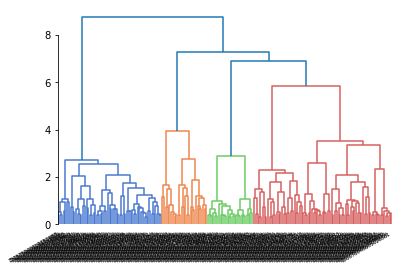

In [16]:
# 7. Dendograme the results.

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette

import matplotlib.pyplot as plt
import matplotlib.colors as mcl
import seaborn as sns

set_link_color_palette([mcl.to_hex(c) for c in sns.color_palette('muted', 10)])

# To generate a linkage, we have to bring the matrix from square-form to vector-form
aba_vec = squareform(aba_dist, checks=False)

# Generate linkage
Z = linkage(aba_vec, method='ward')

# Plot a dendrogram
dn = dendrogram(Z, labels=aba_dist.columns)

ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

sns.despine(trim=True, bottom=True)

In [17]:
from scipy.cluster.hierarchy import fcluster
cl = fcluster(Z, t=.8, criterion='distance')
max(cl)
up_cl=cl
cl

array([34, 34, 33, 25, 27, 28, 28, 26, 26, 26, 25, 66, 52, 72, 18, 70,  1,
       72, 67, 51,  6, 14, 17, 69, 19, 15, 57,  2,  5, 16,  1, 11, 67, 20,
       11, 52, 33, 22, 63, 13, 56, 62,  8, 72, 18, 12, 21, 11, 63, 33, 13,
       56, 20, 65, 17,  8,  6,  9, 49, 58, 42, 10, 50, 58, 60, 32, 32, 54,
       41, 44, 42, 73, 44, 47, 46, 59, 59, 37, 37, 38, 53, 66, 40, 37, 37,
       40, 73, 23, 73, 37, 37, 40, 66, 41, 64, 48, 71, 73, 73, 19, 19, 19,
        6, 68, 19, 51, 67, 16, 21, 22,  6,  3, 72, 18, 22,  5, 63, 11, 70,
       13, 57, 13, 69, 11, 19, 11, 17, 15,  7, 22,  7, 62, 58,  5, 72, 56,
       12, 63,  1,  2,  4,  9, 49, 61, 50, 58, 41, 10, 60, 73, 58, 39, 61,
       73, 38, 46, 41, 47, 38, 38, 45, 40, 38, 38, 40, 53, 45, 59, 54, 49,
       38, 38, 38, 55, 58, 64, 43, 40, 45, 24, 50, 29, 35, 29, 32, 36, 30,
       30, 31, 26], dtype=int32)

In [18]:
l2_sk[up_cl==1]

,type,name,id,n_nodes,n_connectors,n_branches,n_leafs,cable_length,soma,units
0,navis.TreeNeuron,None,720575940626057853,581,None,119,288,1.492534e+06,None,1 nanometer
1,navis.TreeNeuron,None,720575940619753819,519,None,115,264,1.391844e+06,None,1 nanometer
2,navis.TreeNeuron,None,720575940619351488,491,None,114,240,1.286659e+06,None,1 nanometer
